In [1]:
import tidy3d
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import gdstk

## Import the gds

In [2]:
file_loc = r'iosmfnit_export.gds'
lib_loaded = gdstk.read_gds(file_loc)

In [3]:
# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

Cell names: x_wdm_arc_CDNS_707149194557, x_wdm_arc_CDNS_707149194555, x_wdm_circle_CDNS_707149194556, x_wdm_circle_CDNS_707149194554, arcbo_CDNS_7071491945510, arcbo_CDNS_707149194559, x_iosmf_half_CDNS_707149194558, x_iosmf_half_CDNS_707149194553, arcbo_CDNS_707149194552, arcbo_CDNS_707149194551, iosmfnit_CDNS_707149194550, iosmfnit_export


In [4]:
cell_loaded = all_cells["iosmfnit_CDNS_707149194550"]

In [5]:
base = gdstk.rectangle(
    cell_loaded.bounding_box()[0],
    cell_loaded.bounding_box()[1],
    layer=0,  # needs to be layer 0 to work with iosmifnit_stack.stack 
)

cell_loaded.add(base)

# Make the stack

In [6]:
import iosmfnit_stack

In [7]:
dilation = 0.0
sidewall_angle = 87
reference_plane = "bottom"

In [8]:
def draw_top(cell, z0=-400, stack=iosmfnit_stack.stack):
    structures = []
    for key, val in stack.items():
        if key == 'Nit WG':
            z0 = z0 - iosmfnit_stack.stack['ILD Oxide']['thick']
            geo = td.Geometry.from_gds(cell, gds_layer=val['layer'], axis=2, 
                                   slab_bounds=(z0, z0 + val['thick']), reference_plane=reference_plane)
            z0 = z0 + val['thick'] + 0.025
        else:
            geo = td.Geometry.from_gds(cell, gds_layer=val['layer'], axis=2, 
                                   slab_bounds=(z0, z0 + val['thick']), reference_plane=reference_plane)
            z0 = z0 + val['thick']
        structure = td.Structure(geometry=geo, medium=td.Medium(permittivity = val['index']**2))
        structures.append(structure)
    return structures

In [9]:
structures = draw_top(cell_loaded)

# Draw the simulation

In [10]:
# Simulation size along propagation direction
sim_length_x = 847
sim_length_y = 35

# Spacing between waveguides and PML
pml_spacing = 1
sim_size = (
    sim_length_x,
    sim_length_y,
    20,
)

# grid size in each direction
dl = 0.020

### Initialize and visualize simulation ###
sim = td.Simulation(
    center=(1001.5 + 848.5/2, 0, 2.186 + (0.3/2)),
    size=sim_size,
    grid_spec=td.GridSpec.uniform(dl=dl),
    structures=structures,
    run_time=12e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

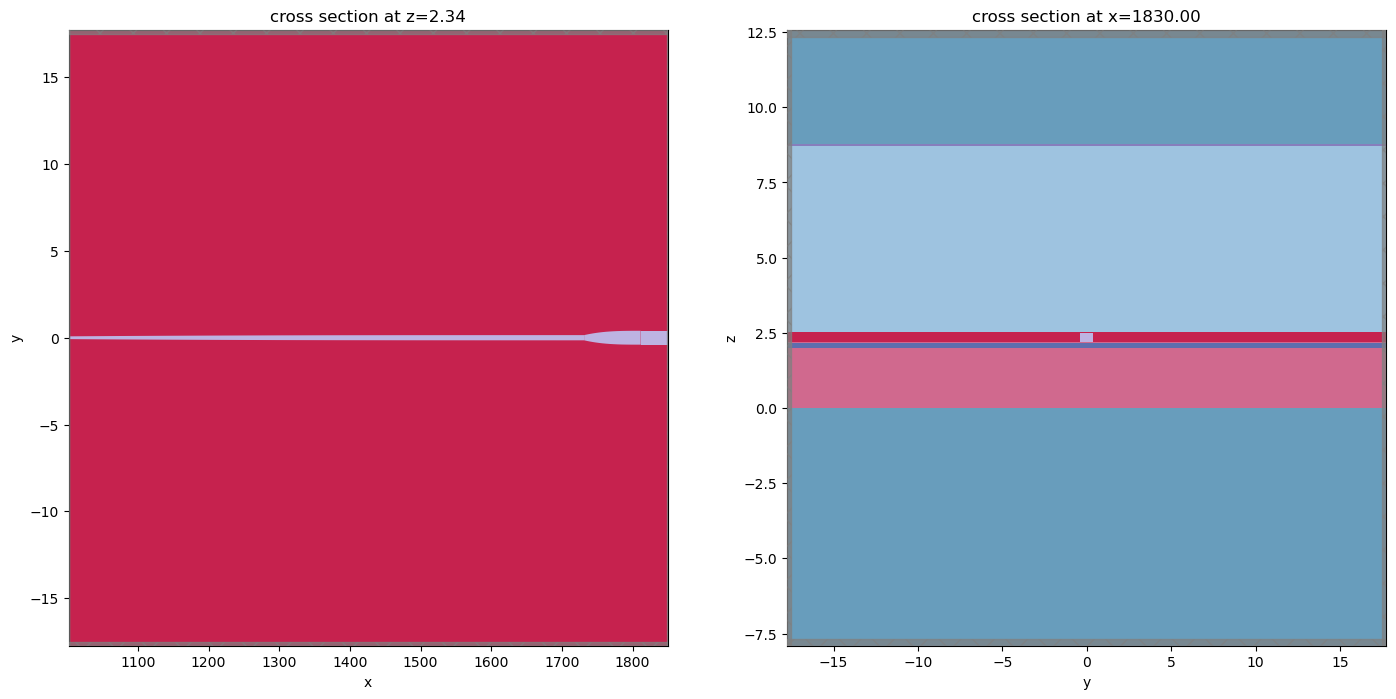

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

sim.plot(z=sim.center[-1], lw=1, edgecolor="k", ax=ax1)
sim.plot(x=1001.5 + 848.5 - 20, lw=1, edgecolor="k", ax=ax2)

ax1.set_aspect(12)
ax2.set_aspect(8)

# ax1.set_ylim([-3, 3])
# _ = ax2.set_ylim([sim.center[-1] - .2, sim.center[-1] + .2])
ax1.set_aspect('auto')
ax2.set_aspect('auto')

# Mode solving

In [12]:
from tidy3d.plugins.mode import ModeSolver

In [13]:
from tidy3d.constants import C_0

In [14]:
# central frequency
wvl_um = 1.310
freq0 = C_0 / wvl_um
fwidth = freq0 / 3

## Solve for mode at the beginning of the structure

In [15]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.,
)

num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

plane = td.Box(center=(1001.5 + 1, 0., 2.186 + (0.3/2)), size=(0, 10, 3.5))

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freq0,
)
mode_data = mode_solver.solve()

[19:52:28] WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

[19:52:36] WARNING: Mode field at frequency index 0, mode index 1 does not decay
           at the plane boundaries.                                             

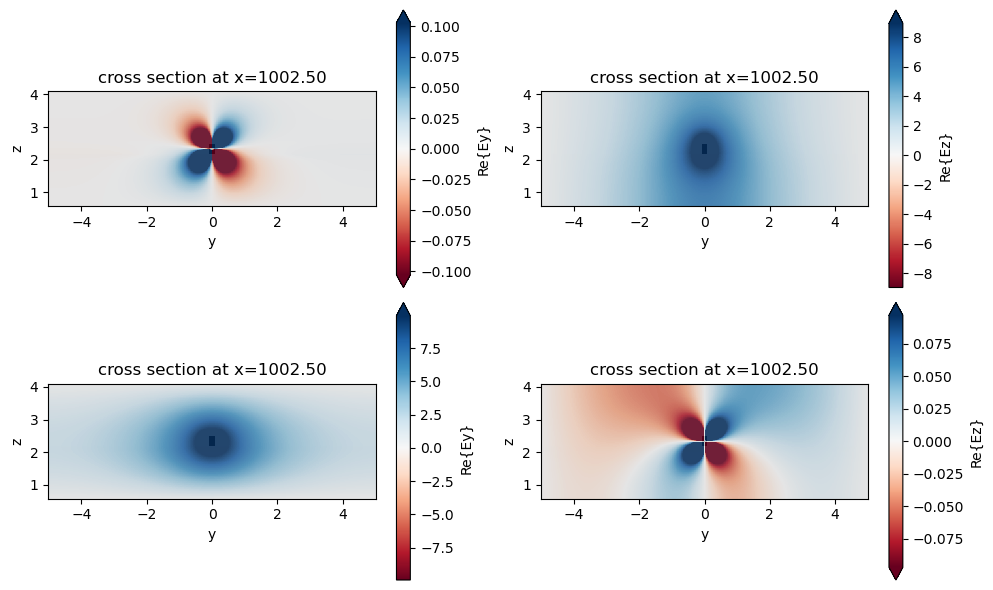

In [16]:
f, axs = plt.subplots(2, 2, tight_layout=False, figsize=(10, 6))
mode_solver.plot_field("Ey", "real", mode_index=0, f=freq0, ax=axs[0,0])
mode_solver.plot_field("Ez", "real", mode_index=0, f=freq0, ax=axs[0,1])
mode_solver.plot_field("Ey", "real", mode_index=2, f=freq0, ax=axs[1,0])
mode_solver.plot_field("Ez", "real", mode_index=2, f=freq0, ax=axs[1,1])
plt.show()

From the above, it appears we should select mode `2` for launching.

## Solve for mode near end of structure

In [17]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.,
)

num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

plane = td.Box(center=(1001.5 + 848.5 - 2, 0., 2.186 + (0.3/2)), size=(0, 10, 3.5))

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freq0,
)
mode_data = mode_solver.solve()

[19:53:26] WARNING: Mode field at frequency index 0, mode index 2 does not decay
           at the plane boundaries.                                             

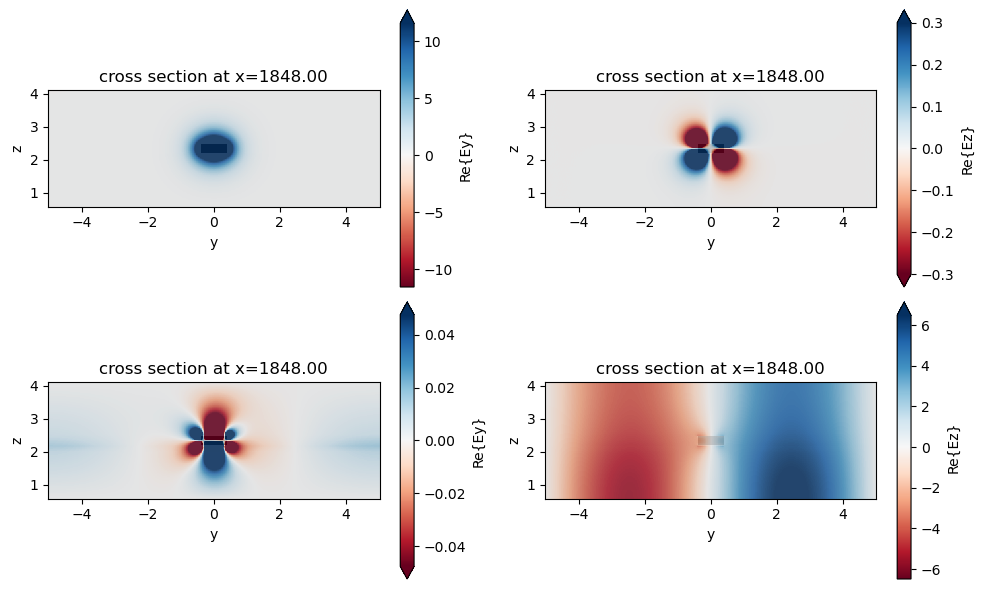

In [18]:
f, axs = plt.subplots(2, 2, tight_layout=False, figsize=(10, 6))
mode_solver.plot_field("Ey", "real", mode_index=0, f=freq0, ax=axs[0,0])
mode_solver.plot_field("Ez", "real", mode_index=0, f=freq0, ax=axs[0,1])
mode_solver.plot_field("Ey", "real", mode_index=2, f=freq0, ax=axs[1,0])
mode_solver.plot_field("Ez", "real", mode_index=2, f=freq0, ax=axs[1,1])
plt.show()

Clearly for the end of the structure, we should select mode `0`.

# FDTD preparation

In [19]:
num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

In [20]:
mode_spec_source = td.ModeSpec(num_modes=3, target_neff=2.)
mode_spec_end = mode_spec_source

# add a mode source as excitation
mode_source = td.ModeSource(
    center=(1001.5 + 1, 0., 2.186 + (0.3/2)),
    size=(0, 10, 3.5),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec_source,
    mode_index=2,
)

mode_monitor_end = td.ModeMonitor(
    center=(1001.5 + 848.5 - 2., 0, 2.186 + (0.3/2)),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec_end,
    name="end",
)

# add a field monitor to visualize the field distribution
field_monitor = td.FieldMonitor(
    center=sim.center, size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

[19:53:41] WARNING: Default value for the field monitor 'colocate' setting has  
           changed to 'True' in Tidy3D 2.4.0. All field components will be      
           colocated to the grid boundaries. Set to 'False' to get the raw      
           fields on the Yee grid instead.                                      

In [21]:
sio2 = td.material_library["SiO2"]["Horiba"]

In [22]:
sim.shutoff

1e-05

# Run

In [28]:
850e-6/3e8*1.4

3.966666666666666e-12

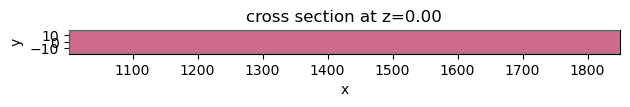

In [24]:
run_time = 5e-12  # simulation run time

# construct simulation
sim_pml = td.Simulation(
    center=sim.center,
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wvl_um),
    structures=structures,
    sources=[mode_source],
    monitors=[mode_monitor_end, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    shutoff=1e-4,
)

# plot simulation
sim_pml.plot(z=0)
plt.show()

In [25]:
sims = {
    "iosmfnit": sim_pml,
}

batch = web.Batch(simulations=sims, verbose=True)
batch.estimate_cost()

[19:58:35] Created task 'iosmfnit' with task_id                                 
           'fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a'.

           View task using web UI at                                            
           ]8;id=253643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=43137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a\taskId]8;;\]8;id=253643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a\=]8;;\]8;id=195120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a\fdve]8;;\]8;id=253643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a\-2eb087ac-dc9d-]8;;\
           ]8;id=253643;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2eb087ac-dc9d-434c-b3d7-c1642f35125a\434c-b3d7-c1642f35125a']8;;\.

Output()

74.94422443719182

In [26]:
job = web.Job(simulation=sim_pml, task_name="mode_simulation", verbose=True)

[20:02:49] Created task 'mode_simulation' with task_id                          
           'fdve-5095f8db-9794-4726-90cf-86f234fb37cd'.

           View task using web UI at                                            
           ]8;id=102845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=837266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\taskId]8;;\]8;id=102845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\=]8;;\]8;id=476185;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\fdve]8;;\]8;id=102845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\-5095f8db-9794-]8;;\
           ]8;id=102845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\4726-90cf-86f234fb37cd']8;;\.

Output()

In [27]:
sim_data = job.run(path="data/iosmfnit/simulation_data_GF_Stack.hdf5")

[20:03:02] status = queued

Output()

[20:03:15] status = preprocess

[20:03:21] Maximum FlexCredit cost: 74.944. Use 'web.real_cost(task_id)' to get 
           the billed FlexCredit cost after a simulation run.

           starting up solver

           running solver

           To cancel the simulation, use 'web.abort(task_id)' or                
           'web.delete(task_id)' or abort/delete the task in the web UI.        
           Terminating the Python script will not stop the job running on the   
           cloud.

Output()

[21:29:51] status = postprocess

Output()

[21:30:11] status = success

           View simulation result at                                            
           ]8;id=751586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=426241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\taskId]8;;\]8;id=751586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\=]8;;\]8;id=846278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\fdve]8;;\]8;id=751586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\-5095f8db-9794-]8;;\
           ]8;id=751586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5095f8db-9794-4726-90cf-86f234fb37cd\4726-90cf-86f234fb37cd']8;;\.

Output()

[21:30:46] loading SimulationData from                                          
           data/iosmfnit/simulation_data_GF_Stack.hdf5

[21:30:47] WARNING: Simulation final field decay value of 0.106 is greater than 
           the simulation shutoff threshold of 0.0001. Consider simulation again
           with large run_time duration for more accurate results.              